# HW 5 Question 2 Nonlinear Advection-Diffusion-Reaction Inverse problem

In [1]:
import dolfin as dl
import numpy as np

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_DIR', "../../") )

from hippylib import *

import logging

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'font.family': 'Times'})

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/Users/afzal-admin/opt/anaconda3/envs/fenics_environment/lib/python3.9/site-packages/dolfin/jit/jit.py:121

# create mesh, define function spaces, and functions

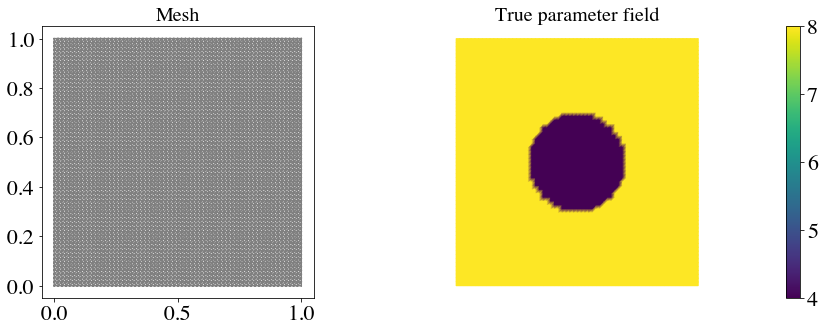

In [2]:
nx = 64
ny = 64
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and initial guess inverted parameter
mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

# define function for state and adjoint
u = dl.Function(Vu)
m = dl.Function(Vm)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

# initialize input functions
f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
v  = dl.Constant((1.0, 0.0))#advective velocity vector
u0 = dl.Constant(0.0)       #BC
k  = dl.Constant(1.0)       #Diffusion parameter

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
plt.show()

In [3]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

In [4]:
# Class HessianOperator to perform Hessian apply to a vector
class HessianOperator():
    cgiter = 0
    def __init__(self, R, Wmm, C, A, adj_A, W, Wum, bc0, use_gaussnewton=False):
        self.R = R
        self.Wmm = Wmm
        self.C = C
        self.A = A
        self.adj_A = adj_A
        self.W = W
        self.Wum = Wum
        self.bc0 = bc0
        self.use_gaussnewton = use_gaussnewton
        
        # incremental state
        self.du = dl.Vector()
        self.A.init_vector(self.du,0)
        
        #incremental adjoint
        self.dp = dl.Vector()
        self.adj_A.init_vector(self.dp,0)
        
        # auxiliary vector
        self.Wum_du = dl.Vector()
        self.Wum.init_vector(self.Wum_du, 1)
        
    def init_vector(self, v, dim):
        self.R.init_vector(v,dim)

    # Hessian performed on v, output as generic vector y
    def mult(self, v, y):
        self.cgiter += 1
        y.zero()
        if self.use_gaussnewton:
            self.mult_GaussNewton(v,y)
        else:
            self.mult_Newton(v,y)
            
    # define (Gauss-Newton) Hessian apply H * v
    def mult_GaussNewton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = - (self.W * self.du)
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        # Misfit term
        self.C.transpmult(self.dp, y)
        
        if self.R:
            Rv = self.R*v
            y.axpy(1, Rv)
        
    # define (Newton) Hessian apply H * v
    def mult_Newton(self, v, y):
        
        #incremental forward
        rhs = -(self.C * v)
        self.bc0.apply(rhs)
        dl.solve (self.A, self.du, rhs)
        
        #incremental adjoint
        rhs = -(self.W * self.du) -  self.Wum * v
        self.bc0.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)
                
        #Misfit term
        self.C.transpmult(self.dp, y)
        
        self.Wum.transpmult(self.du, self.Wum_du)
        y.axpy(1., self.Wum_du)
        
        y.axpy(1., self.Wmm*v)
        
        #Reg/Prior term
        if self.R:
            y.axpy(1., self.R*v)
        

In [5]:
def AddDiffInverseProblem(nx, ny, gamma, v, morozov = False, plot = True, noise_level=0.01, useTV=False):
    np.random.seed(seed=1)
    mesh = dl.UnitSquareMesh(nx, ny)
    Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
    Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

    # The true and initial guess inverted parameter
    mtrue = dl.interpolate(dl.Expression('8. - 4.*(pow(x[0] - 0.5,2) + pow(x[1] - 0.5,2) < pow(0.2,2) )', degree=5), Vm)

    # define function for state and adjoint
    u = dl.Function(Vu)
    m = dl.Function(Vm)
    p = dl.Function(Vu)

    # define Trial and Test Functions
    u_trial, m_trial, p_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vm), dl.TrialFunction(Vu)
    u_test,  m_test,  p_test  = dl.TestFunction(Vu),  dl.TestFunction(Vm),  dl.TestFunction(Vu)

    # initialize input functions
    f = dl.interpolate(dl.Expression('std::max(0.5, exp(-25*(x[0]-0.7)*(x[0]-0.7) - 25 * (x[1]-0.7)*(x[1]-0.7)))', degree=2), Vu)
    v = dl.Constant((1.0, 0.0))
    k = dl.Constant(1.0)
    u0 = dl.Constant(0.0)    
    
    # plot
    plt.figure(figsize=(15,5))
    nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
    nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
    plt.show()
    
    # set up dirichlet boundary conditions
    def boundary(x,on_boundary):
        return on_boundary

    bc_state = dl.DirichletBC(Vu, u0, boundary)
    bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

    
    a_true = dl.inner( dl.exp(mtrue) * dl.grad(u_trial), dl.grad(u_test)) * dl.dx \
            + dl.dot(v, dl.grad(u_trial))*u_test*dl.dx
    L_true = f * u_test * dl.dx
    A_true, b_true = dl.assemble_system(a_true, L_true, bc_state)

    utrue = dl.Function(Vu)
    
    F = k*dl.inner(dl.grad(utrue), dl.grad(u_test)) * dl.dx + \
    dl.inner(v, dl.grad(utrue)) * u_test * dl.dx + \
    100*dl.exp(mtrue)*utrue*utrue*utrue*u_test * dl.dx - \
    f*u_test*dl.dx
    
    dl.solve(F == 0, utrue, bc_state, solver_parameters={"newton_solver": \
                                                     {"relative_tolerance": 1e-6}})    

    ud = dl.Function(Vu)
    ud.assign(utrue)

    # perturb state solution and create synthetic measurements ud
    # ud = u + ||u||/SNR * random.normal
    MAX = ud.vector().norm("linf")
    noise = dl.Vector()
    A_true.init_vector(noise,1)
    noise.set_local( noise_level * MAX * np.random.normal(0, 1, len(ud.vector().get_local())) )
    bc_adj.apply(noise)

    ud.vector().axpy(1., noise)
    
    # define cost function
    def cost(u, ud, m,gamma):
        if useTV:
            reg = gamma * dl.assemble( dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps)*dl.dx ) 
        else:
            reg = 0.5* gamma * dl.assemble( dl.inner(dl.grad(m), dl.grad(m))*dl.dx )
            
        misfit = 0.5 * dl.assemble( (u-ud)**2*dl.dx)
        return [reg + misfit, misfit, reg]
    
    # weak form for setting up the state equation
    
    F_state = dl.inner(k * dl.grad(u) , dl.grad(p_test)) * dl.dx + \
          dl.dot(v, dl.grad(u)) * p_test * dl.dx + \
          dl.Constant(100)*dl.exp(m) * u**3 * p_test * dl.dx - \
          f * p_test * dl.dx

    # weak form for gradient
    CTvarf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx

    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)    
    
    # weak form for setting up the adjoint equation
    
    F_adj = (u - ud) * u_test * dl.dx + k * dl.inner(dl.grad(u_test), dl.grad(p)) * dl.dx + \
    dl.dot(v, dl.grad(u_test)) * p * dl.dx + dl.Constant(300) * dl.exp(m) * u * u * u_test * p * dl.dx

    
    # weak form for gradient
    TVeps = 0.001
    
    CTvarf = dl.Constant(100) * m_test * dl.exp(m) * u**3 * p * dl.dx
    if useTV:
        gradRvarf = ( dl.Constant(gamma)/dl.sqrt(dl.inner(dl.grad(m), dl.grad(m)) + TVeps) )* \
                     dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx
    else:
        gradRvarf = dl.Constant(gamma)*dl.inner(dl.grad(m), dl.grad(m_test))*dl.dx    
    
    # L^2 weighted inner product
    M_varf   = dl.inner(m_trial, m_test) * dl.dx
    M = dl.assemble(M_varf)
    
    m0 = dl.interpolate(dl.Constant(4.), Vm )
    m.assign(m0)

    # solve state equation
    dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
    uk = dl.Function(Vu)
    
    # evaluate cost
    [cost_old, misfit_old, reg_old] = cost(u, ud, m, gamma)
    
    #Hessian varfs
    W_varf   = dl.inner(u_trial, u_test) * dl.dx
    R_varf   = dl.Constant(gamma) * dl.inner(dl.grad(m_trial), dl.grad(m_test)) * dl.dx

    #C_varf   = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * u**3, u_test) * dl.dx
    C_varf = dl.inner(dl.Constant(100) * m_trial* dl.exp(m) * u**3, p_test) * dl.dx 
    Wum_varf = dl.inner(dl.Constant(300) * dl.exp(m) * m_trial * u * u * u_test, p) * dl.dx
    Wmm_varf = dl.inner(dl.Constant(100) * dl.exp(m) * m_trial * m_test *  u**3,  p) * dl.dx

    a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx


    a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
    
    # Assemble constant matrices
    W = dl.assemble(W_varf)
    R = dl.assemble(R_varf)
    
    # define parameters for the optimization
    tol = 5e-7
    c = 1e-4
    maxiter = 20

    # initialize iter counters
    iter = 1
    total_cg_iter = 0
    converged = False

    # initializations
    g, m_delta = dl.Vector(), dl.Vector()
    R.init_vector(m_delta,0)
    R.init_vector(g,0)

    m_prev = dl.Function(Vm)

    print( "Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg" )

    while iter <  maxiter and not converged:

        # solve the adoint problem
        
        dl.solve(F_adj == 0, p, bc_adj, solver_parameters={"newton_solver": {"relative_tolerance": 1e-6}})
        
        #state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
        a_adj = dl.inner(k * dl.grad(u_test), dl.grad(p_trial)) * dl.dx + \
            dl.inner(dl.dot(v, dl.grad(u_test)), p_trial) * dl.dx + \
            dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_test, p_trial) * dl.dx
        
        
        adjoint_A , _= dl.assemble_system(a_adj, dl.Constant(0.) * p_test * dl.dx, bc_adj)
        
        a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx

        
        state_A , _= dl.assemble_system(a_state, dl.Constant(0.) * u_test * dl.dx, bc_state)

        # evaluate the  gradient
        MG = dl.assemble(CTvarf + gradRvarf)

        # calculate the L^2 norm of the gradient
        dl.solve(M, g, MG)
        grad2 = g.inner(MG)
        gradnorm = np.sqrt(grad2)

        # set the CG tolerance (use Eisenstat–Walker termination criterion)
        if iter == 1:
            gradnorm_ini = gradnorm
        tolcg = min(0.5, np.sqrt(gradnorm/gradnorm_ini))
    
        # assemble W_um and W_mm
        C   = dl.assemble(C_varf)
        Wum = dl.assemble(Wum_varf)
        Wmm = dl.assemble(Wmm_varf)

        # define the Hessian apply operator (with preconditioner)
        Hess_Apply = HessianOperator(R, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=(iter<6) )
        P = R + 0.1*gamma * M
        Psolver = dl.PETScKrylovSolver("cg", amg_method())
        Psolver.set_operator(P)
    
        solver = CGSolverSteihaug()
        solver.set_operator(Hess_Apply)
        solver.set_preconditioner(Psolver)
        solver.parameters["rel_tolerance"] = tolcg
        solver.parameters["zero_initial_guess"] = True
        solver.parameters["print_level"] = -1

        # solve the Newton system H a_delta = - MG
        solver.solve(m_delta, -MG)
        total_cg_iter += Hess_Apply.cgiter
    
        # linesearch
        alpha = 1
        descent = 0
        no_backtrack = 0
        m_prev.assign(m)
        while descent == 0 and no_backtrack < 10:
            m.vector().axpy(alpha, m_delta )

            # solve the state/forward problem
            dl.solve(F_state == 0, u, bc_state, solver_parameters={"newton_solver": {"relative_tolerance": 1e-5}})
            a_state = dl.inner(k * dl.grad(u_trial), dl.grad(p_test)) * dl.dx + \
              dl.inner(dl.dot(v, dl.grad(u_trial)), p_test) * dl.dx + \
              dl.inner(dl.Constant(300) * dl.exp(m) * u * u * u_trial, p_test) * dl.dx
            
            state_A = dl.assemble(a_state)
            
            # evaluate cost
            [cost_new, misfit_new, reg_new] = cost(u, ud, m, gamma)

            # check if Armijo conditions are satisfied
            if cost_new < cost_old + alpha * c * MG.inner(m_delta):
                cost_old = cost_new
                descent = 1
            else:
                no_backtrack += 1
                alpha *= 0.5
                m.assign(m_prev)  # reset a

        # calculate sqrt(-G * D)
        graddir = np.sqrt(- MG.inner(m_delta) )

        sp = ""
        print( "%2d %2s %2d %3s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %5.2f %1s %5.3e" % \
            (iter, sp, Hess_Apply.cgiter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
             graddir, sp, gradnorm, sp, alpha, sp, tolcg) )

        # check for convergence
        if gradnorm < tol and iter > 1:
            converged = True
            print( "Newton's method converged in ",iter,"  iterations" )
            print( "Total number of CG iterations: ", total_cg_iter )
        
        iter += 1
    
    if not converged:
        print( "Newton's method did not converge in ", maxiter, " iterations" )
    
    if plot:
        nb.multi1_plot([mtrue, m], ["mtrue", "m"])
        if useTV:
            plt.title("TV_nx%.f_Beta%.1e" %(nx,gamma))
            plt.savefig("HW5_Q2_TV_%.f_%.1e_.pdf" %(nx,gamma)) 
        else:
            plt.title("TN_nx%.f_Beta%.1e" %(nx,gamma))
            plt.savefig("HW5_Q2_TN_%.f_%.1e_.pdf" %(nx,gamma))        
        plt.show()
    
    Mstate = dl.assemble(u_trial*u_test*dl.dx)
    noise_norm2 = noise.inner(Mstate*noise)

    if not morozov:
        Hmisfit = HessianOperator(None, Wmm, C, state_A, adjoint_A, W, Wum, bc_adj, use_gaussnewton=True)
        k = 50
        p = 20

        Omega = MultiVector(m.vector(), k+p)
        parRandom.normal(1., Omega)
        lmbda, evecs = doublePassG(Hmisfit, P, Psolver, Omega, k)

        plt.plot(range(0,k), lmbda, 'b*', range(0,k+1), np.ones(k+1), '-r')
        plt.yscale('log')
        plt.xlabel('number')
        plt.ylabel('eigenvalue')
        plt.show()

        nb.plot_eigenvectors(Vm, evecs, mytitle="Eigenvector", which=[0,1,2,5,10,15])
        plt.show()

        
    
    return Vm.dim(), iter, total_cg_iter, noise_norm2, cost_new, misfit_new, reg_new

# Part 2.2: FEniCS implementation of the inexact Newton and Gauss-Newton methods

****** Computing solution with gamma =  1e-07 ******


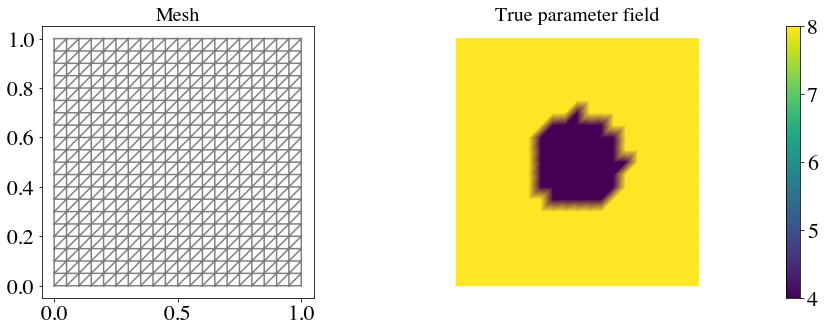

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39211e-06   2.39180e-06   3.08348e-10   8.28223e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.87116e-07   8.86921e-07   1.94405e-10   1.71294e-03   6.67027e-06    1.00   4.795e-01
 3     2     6.35466e-07   4.73768e-07   1.61698e-07   7.14581e-04   2.45943e-06    1.00   2.911e-01
 4     2     6.27311e-07   4.66489e-07   1.60821e-07   1.27295e-04   4.59873e-07    1.00   1.259e-01
Newton's method converged in  4   iterations
Total number of CG iterations:  6


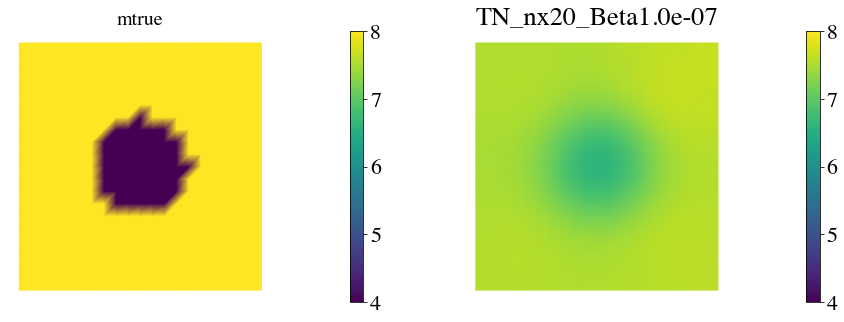

****** Computing solution with gamma =  1e-08 ******


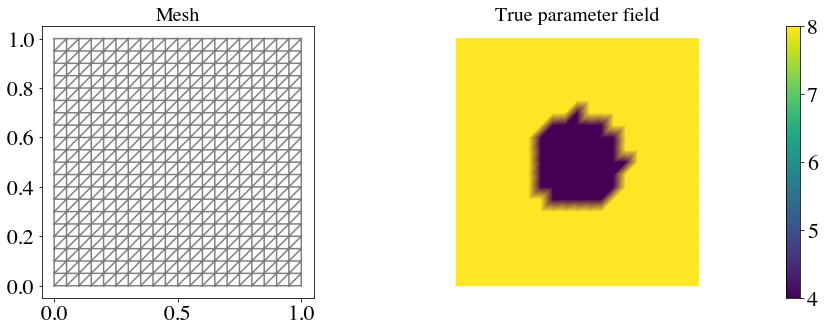

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39195e-06   2.39192e-06   3.08353e-11   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86966e-07   8.86946e-07   1.95306e-11   1.71293e-03   6.63176e-06    1.00   4.781e-01
 3     2     3.17108e-07   2.14247e-07   1.02861e-07   1.11346e-03   2.43785e-06    1.00   2.899e-01
 4     1     2.96945e-07   1.94062e-07   1.02882e-07   2.00319e-04   1.31142e-06    1.00   2.126e-01
 5     2     2.26149e-07   1.22632e-07   1.03517e-07   3.76363e-04   1.02233e-06    1.00   1.877e-01
 6     8     2.16710e-07   8.67597e-08   1.29950e-07   1.37174e-04   2.80907e-07    1.00   9.839e-02
Newton's method converged in  6   iterations
Total number of CG iterations:  15


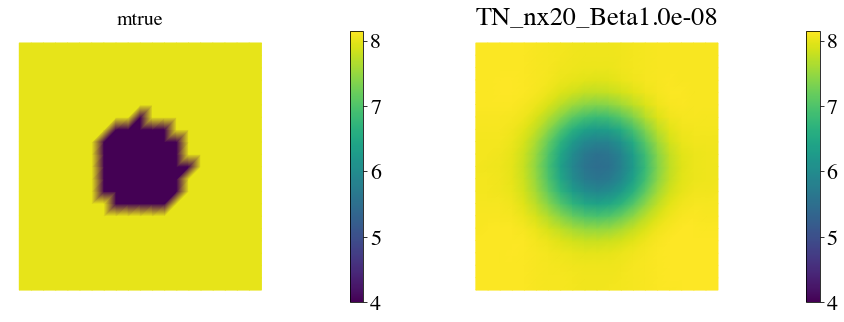

****** Computing solution with gamma =  1e-09 ******


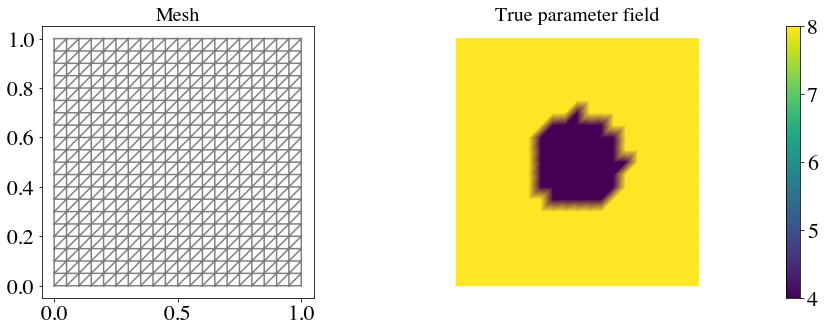

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39194e-06   2.39193e-06   3.08354e-12   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86950e-07   8.86949e-07   1.95397e-12   1.71293e-03   6.62792e-06    1.00   4.779e-01
 3     4     1.56891e-07   1.37518e-07   1.93734e-08   1.29293e-03   2.43571e-06    1.00   2.897e-01
 4     1     7.57069e-08   5.63257e-08   1.93812e-08   4.03173e-04   1.37358e-06    1.00   2.176e-01
 5    10     5.47632e-08   2.44690e-08   3.02942e-08   2.15585e-04   2.76696e-07    1.00   9.765e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  17


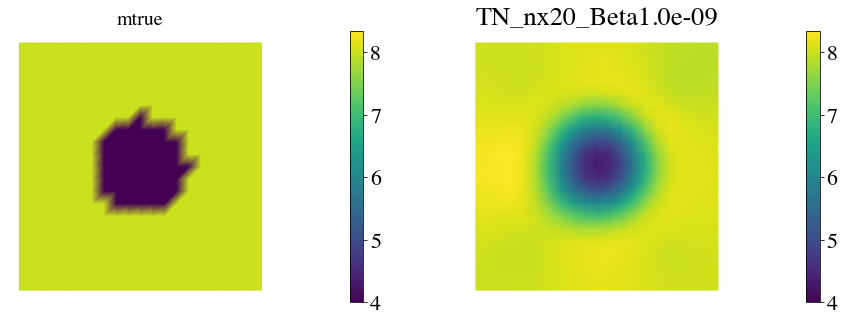

****** Computing solution with gamma =  1e-10 ******


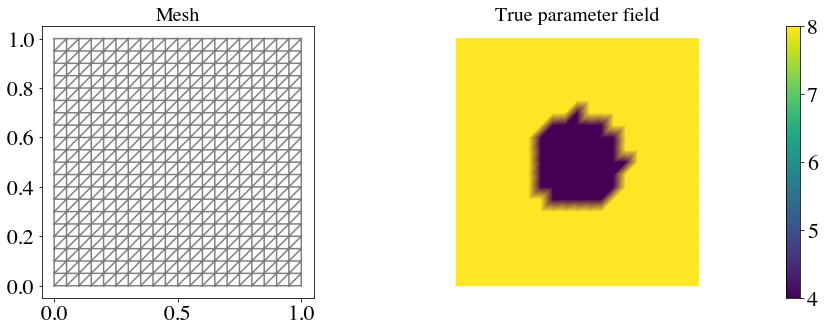

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39194e-06   2.39193e-06   3.08354e-13   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86949e-07   8.86949e-07   1.95406e-13   1.71293e-03   6.62753e-06    1.00   4.779e-01
 3     4     1.45293e-07   1.43270e-07   2.02283e-09   1.30664e-03   2.43549e-06    1.00   2.897e-01
 4     1     5.67947e-08   5.47711e-08   2.02367e-09   4.20957e-04   1.42692e-06    1.00   2.218e-01
 5    14     2.67074e-08   2.23035e-08   4.40394e-09   2.76277e-04   2.99122e-07    1.00   1.015e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


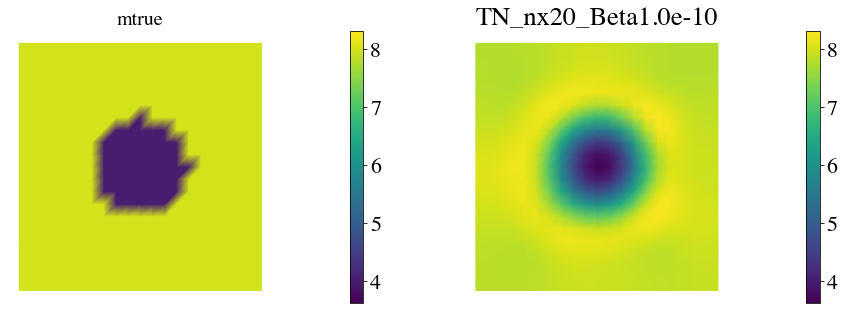

****** Computing solution with gamma =  1e-11 ******


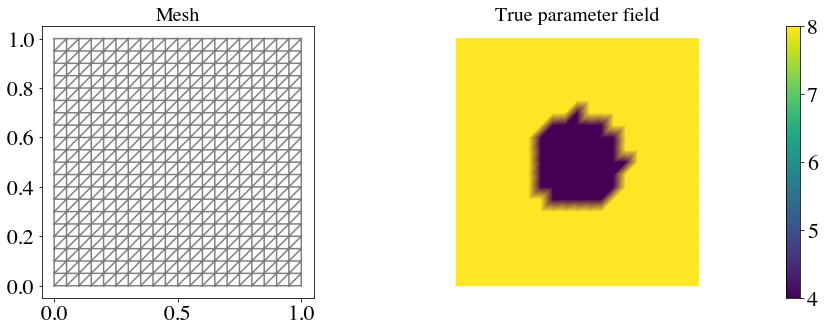

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39194e-06   2.39194e-06   3.08354e-14   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86949e-07   8.86949e-07   1.95407e-14   1.71293e-03   6.62749e-06    1.00   4.779e-01
 3     4     1.44118e-07   1.43914e-07   2.03169e-10   1.30804e-03   2.43547e-06    1.00   2.897e-01
 4     1     5.48445e-08   5.46413e-08   2.03253e-10   4.22796e-04   1.43243e-06    1.00   2.222e-01
 5    14     2.38884e-08   2.34268e-08   4.61651e-10   2.83865e-04   3.01552e-07    1.00   1.019e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


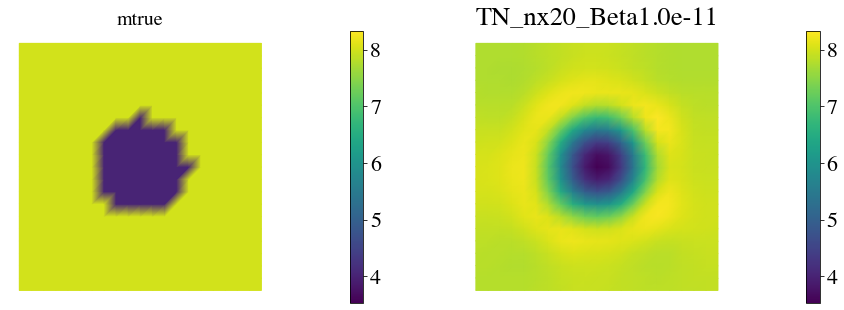

In [6]:
n = 20
gammas = [1e-7, 1e-8, 1e-9, 1e-10, 1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n, n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)



****** Computing solution with gamma =  1e-07 ******


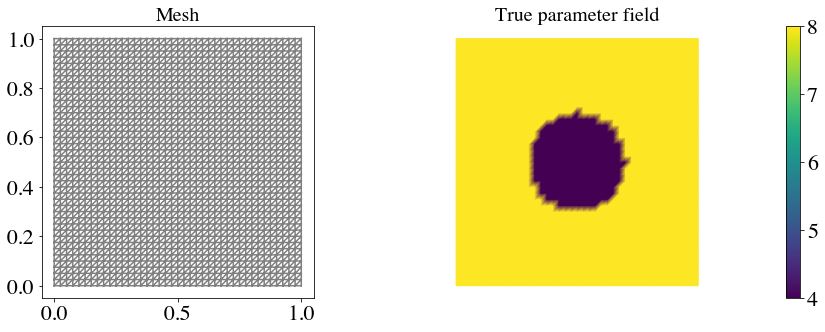

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40078e-06   2.40046e-06   3.15995e-10   8.34208e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90222e-07   8.90022e-07   2.00307e-10   1.71629e-03   6.63162e-06    1.00   4.763e-01
 3     2     6.40639e-07   4.88744e-07   1.51894e-07   7.12266e-04   2.47579e-06    1.00   2.910e-01
 4     2     6.25700e-07   4.73474e-07   1.52226e-07   1.72285e-04   5.91173e-07    1.00   1.422e-01
 5     5     6.24711e-07   4.55722e-07   1.68989e-07   4.40279e-05   1.60078e-07    1.00   7.400e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  11


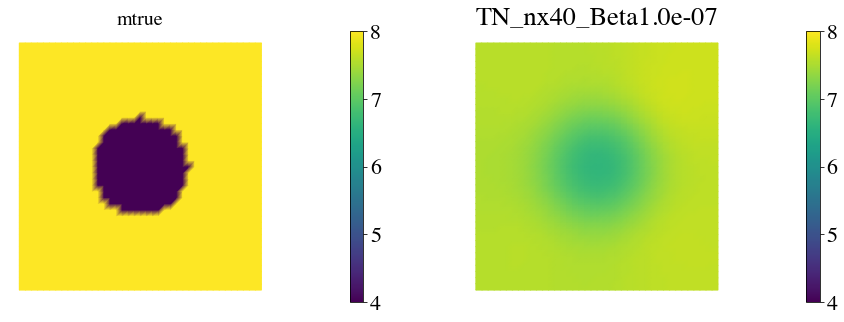

****** Computing solution with gamma =  1e-08 ******


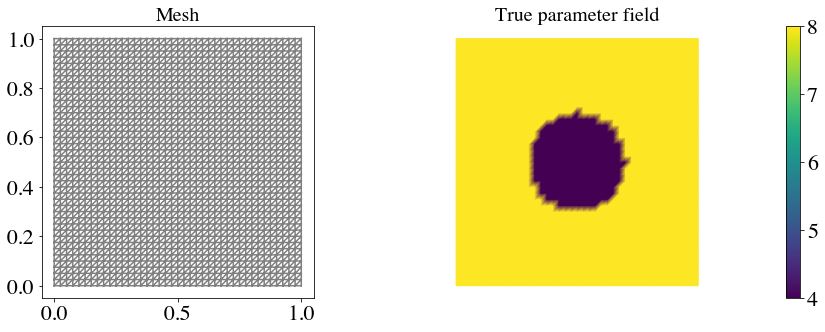

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40062e-06   2.40059e-06   3.16000e-11   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90067e-07   8.90047e-07   2.01243e-11   1.71628e-03   6.59294e-06    1.00   4.749e-01
 3     4     2.57755e-07   1.28229e-07   1.29526e-07   1.17970e-03   2.45465e-06    1.00   2.898e-01
 4     1     2.21672e-07   9.21065e-08   1.29566e-07   2.68645e-04   9.66631e-07    1.00   1.818e-01
 5     8     2.16543e-07   8.70727e-08   1.29470e-07   1.03179e-04   2.14340e-07    1.00   8.563e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  15


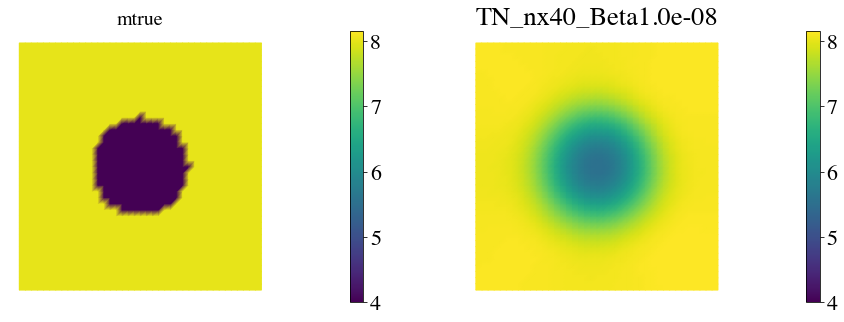

****** Computing solution with gamma =  1e-09 ******


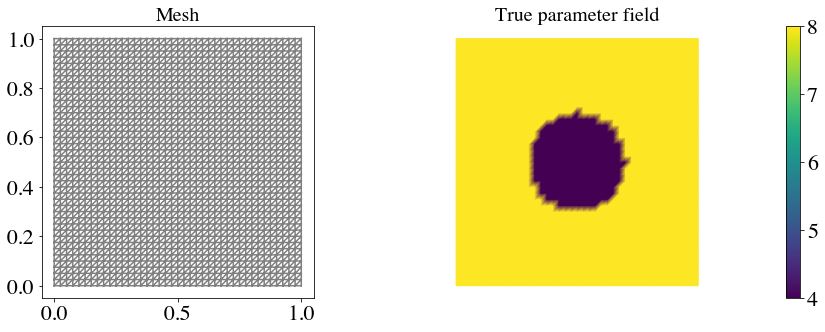

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40060e-06   2.40060e-06   3.16001e-12   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90051e-07   8.90049e-07   2.01337e-12   1.71628e-03   6.58907e-06    1.00   4.748e-01
 3     4     1.56852e-07   1.37901e-07   1.89510e-08   1.29372e-03   2.45256e-06    1.00   2.897e-01
 4     1     7.89440e-08   5.99855e-08   1.89586e-08   3.94951e-04   1.34723e-06    1.00   2.147e-01
 5     9     5.56203e-08   2.53150e-08   3.03052e-08   2.28095e-04   2.99159e-07    1.00   1.012e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  16


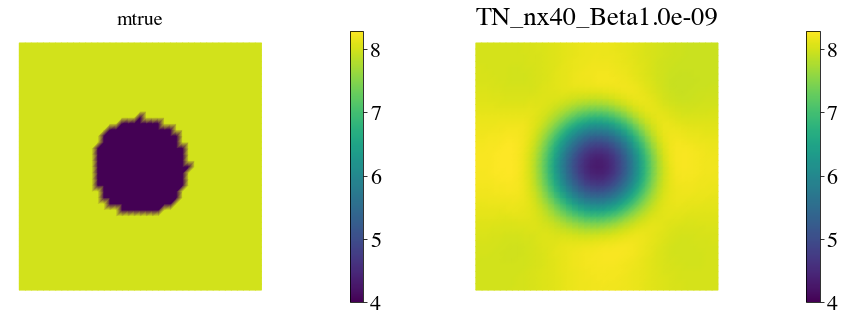

****** Computing solution with gamma =  1e-10 ******


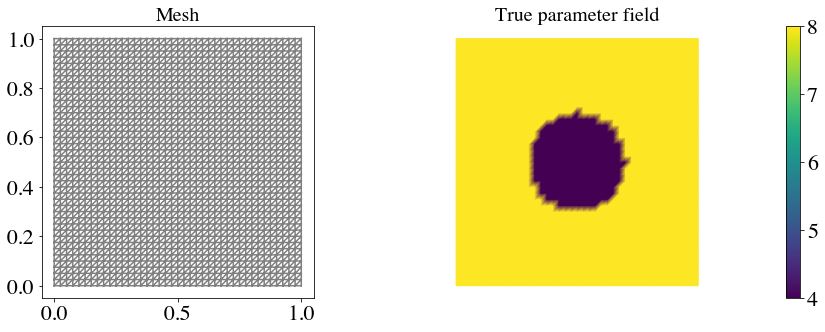

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40060e-06   2.40060e-06   3.16001e-13   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90050e-07   8.90049e-07   2.01346e-13   1.71628e-03   6.58869e-06    1.00   4.748e-01
 3     4     1.45222e-07   1.43244e-07   1.97715e-09   1.30712e-03   2.45235e-06    1.00   2.896e-01
 4     1     6.04232e-08   5.84452e-08   1.97796e-09   4.12060e-04   1.39859e-06    1.00   2.187e-01
 5    14     2.84545e-08   2.40379e-08   4.41659e-09   2.88386e-04   3.20965e-07    1.00   1.048e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


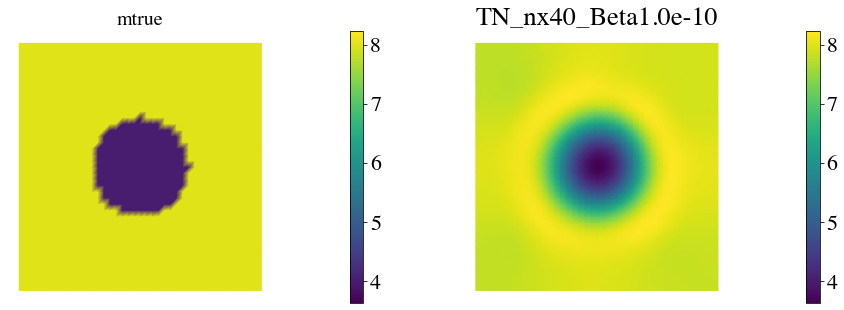

In [7]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n, n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

****** Computing solution with gamma =  1e-07 ******


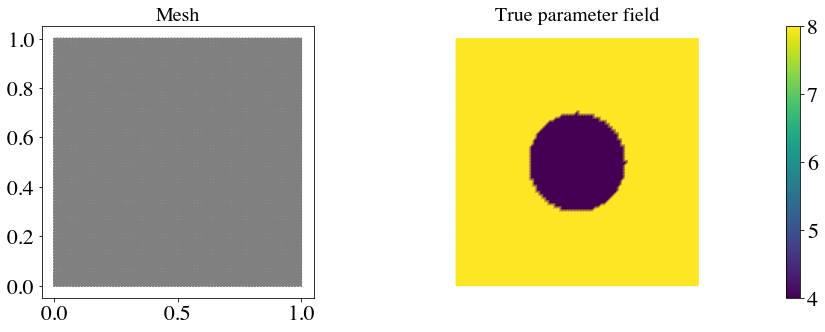

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39213e-06   2.39181e-06   3.19586e-10   8.37850e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77489e-07   8.77286e-07   2.03031e-10   1.71892e-03   6.59778e-06    1.00   4.740e-01
 3     2     6.32832e-07   4.86639e-07   1.46193e-07   7.05364e-04   2.46065e-06    1.00   2.895e-01
 4     2     6.16227e-07   4.69343e-07   1.46884e-07   1.81640e-04   6.16950e-07    1.00   1.449e-01
 5     5     6.15044e-07   4.48920e-07   1.66124e-07   4.82768e-05   1.69202e-07    1.00   7.590e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  11


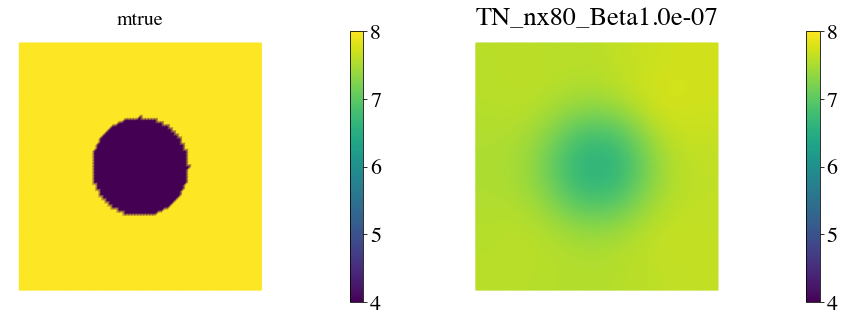

****** Computing solution with gamma =  1e-08 ******


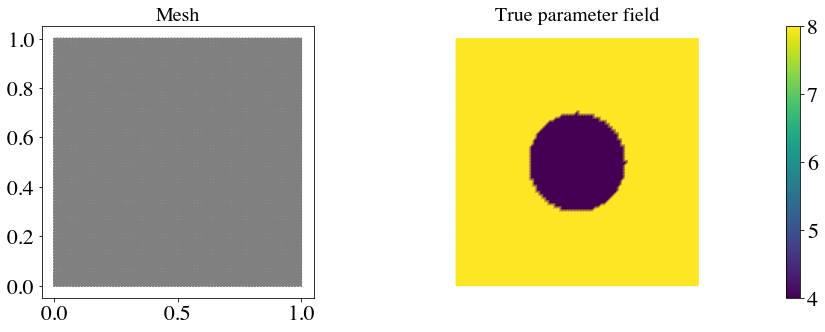

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39197e-06   2.39193e-06   3.19591e-11   8.37853e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77330e-07   8.77310e-07   2.03986e-11   1.71891e-03   6.55901e-06    1.00   4.726e-01
 3     4     2.54446e-07   1.27903e-07   1.26543e-07   1.16997e-03   2.43965e-06    1.00   2.882e-01
 4     1     2.20280e-07   9.36985e-08   1.26581e-07   2.61416e-04   9.38113e-07    1.00   1.787e-01
 5     8     2.14953e-07   8.76785e-08   1.27274e-07   1.04943e-04   2.16626e-07    1.00   8.588e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  15


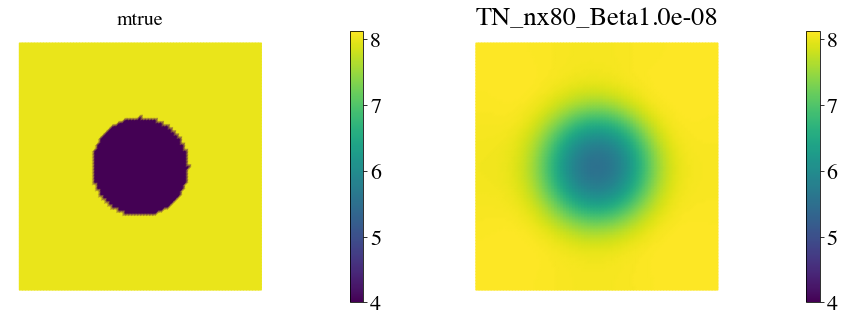

****** Computing solution with gamma =  1e-09 ******


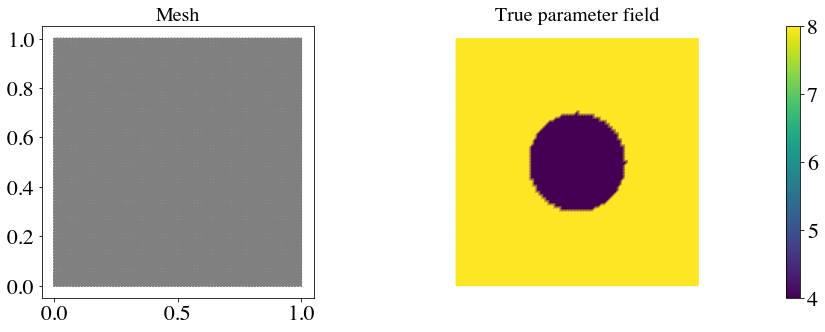

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39195e-06   2.39195e-06   3.19591e-12   8.37854e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77314e-07   8.77312e-07   2.04082e-12   1.71891e-03   6.55514e-06    1.00   4.724e-01
 3     4     1.54620e-07   1.36140e-07   1.84804e-08   1.28223e-03   2.43756e-06    1.00   2.881e-01
 4     1     8.10954e-08   6.26077e-08   1.84877e-08   3.83684e-04   1.30719e-06    1.00   2.110e-01
 5    10     5.65192e-08   2.62964e-08   3.02228e-08   2.34729e-04   3.06276e-07    1.00   1.021e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


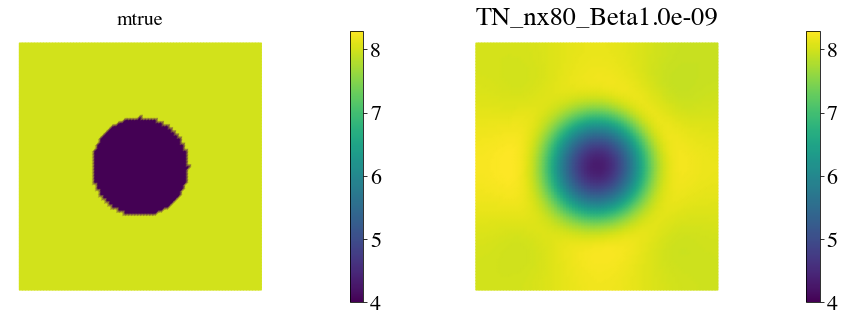

****** Computing solution with gamma =  1e-10 ******


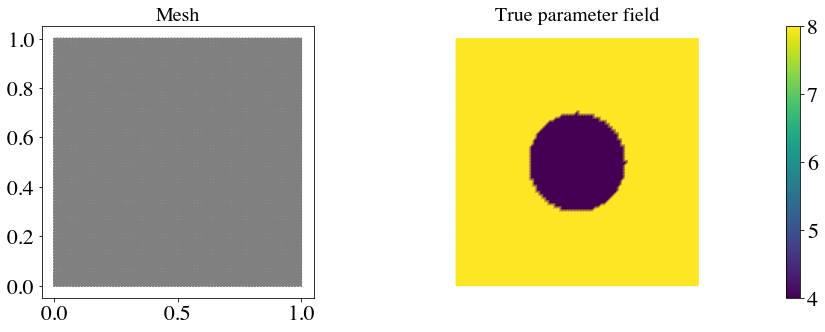

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39195e-06   2.39195e-06   3.19591e-13   8.37854e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77313e-07   8.77313e-07   2.04091e-13   1.71891e-03   6.55475e-06    1.00   4.724e-01
 3     4     1.43063e-07   1.41135e-07   1.92763e-09   1.29541e-03   2.43735e-06    1.00   2.881e-01
 4     1     6.30634e-08   6.11350e-08   1.92841e-09   4.00235e-04   1.35700e-06    1.00   2.150e-01
 5    15     2.99376e-08   2.55380e-08   4.39961e-09   2.94794e-04   3.27908e-07    1.00   1.057e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


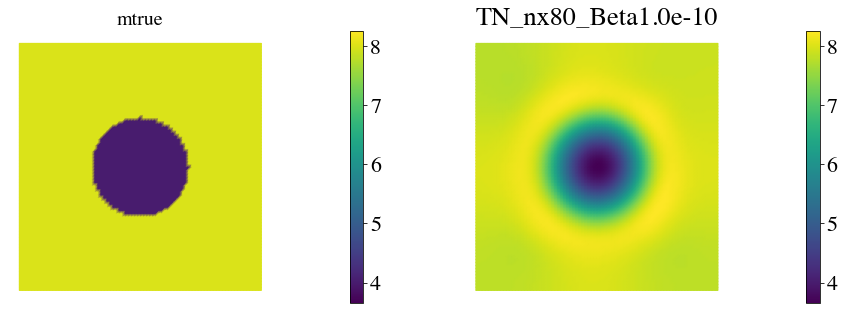

In [8]:
n = 80
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n,n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

# Part 2.3: Consider two noise levels: low noise (1%) and high noise (10%) and find the optimal parameter

****** Computing solution with gamma =  1e-07 ******


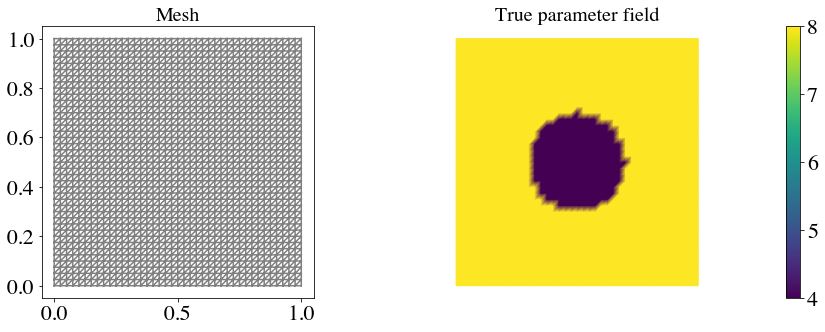

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.53441e-06   3.53410e-06   3.15524e-10   8.33605e-03   2.92101e-05    1.00   5.000e-01
 2     1     2.02250e-06   2.02230e-06   1.99908e-10   1.71708e-03   6.63505e-06    1.00   4.766e-01
 3     2     1.77430e-06   1.62291e-06   1.51394e-07   7.09134e-04   2.44434e-06    1.00   2.893e-01
 4     2     1.76042e-06   1.60854e-06   1.51878e-07   1.66131e-04   5.79379e-07    1.00   1.408e-01
 5     5     1.75942e-06   1.59156e-06   1.67865e-07   4.39982e-05   1.60919e-07    1.00   7.422e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  11


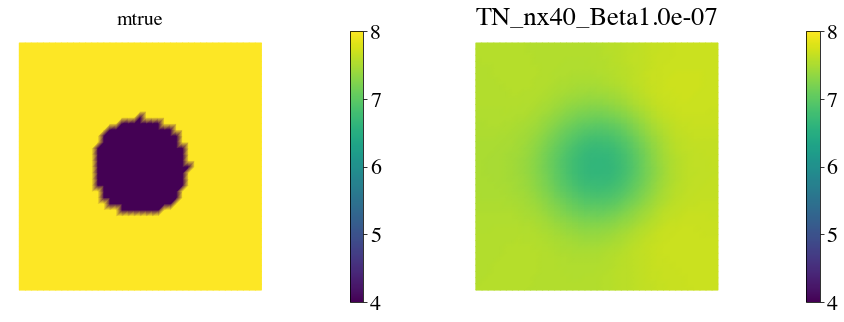

****** Computing solution with gamma =  1e-08 ******


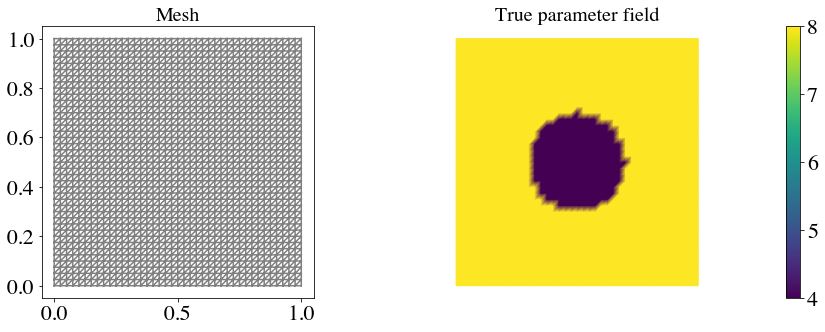

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.53425e-06   3.53422e-06   3.15529e-11   8.33608e-03   2.92101e-05    1.00   5.000e-01
 2     1     2.02234e-06   2.02232e-06   2.00841e-11   1.71707e-03   6.59634e-06    1.00   4.752e-01
 3     4     1.39408e-06   1.26581e-06   1.28269e-07   1.17298e-03   2.42281e-06    1.00   2.880e-01
 4     1     1.35864e-06   1.23033e-06   1.28309e-07   2.66202e-04   9.70468e-07    1.00   1.823e-01
 5     8     1.35313e-06   1.22549e-06   1.27643e-07   1.06707e-04   2.35459e-07    1.00   8.978e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  15


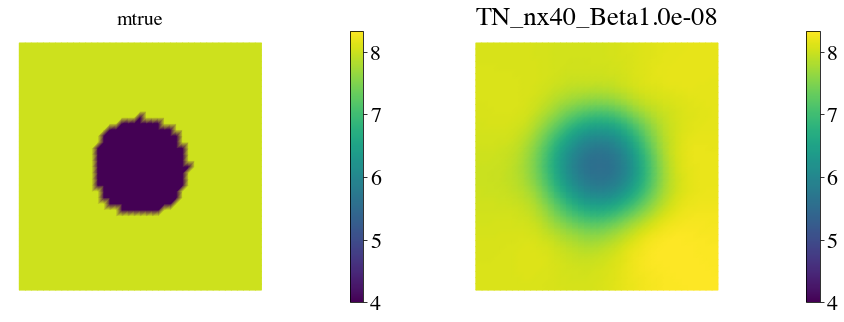

****** Computing solution with gamma =  1e-09 ******


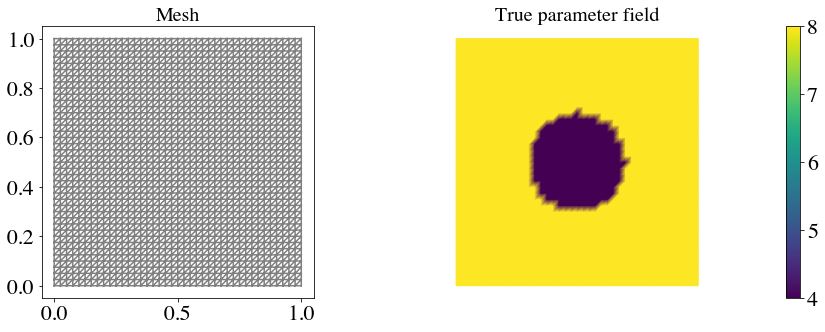

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.53424e-06   3.53423e-06   3.15529e-12   8.33609e-03   2.92101e-05    1.00   5.000e-01
 2     1     2.02233e-06   2.02233e-06   2.00934e-12   1.71707e-03   6.59248e-06    1.00   4.751e-01
 3     4     1.29346e-06   1.27469e-06   1.87795e-08   1.28657e-03   2.42067e-06    1.00   2.879e-01
 4     1     1.21682e-06   1.19803e-06   1.87871e-08   3.91707e-04   1.34914e-06    1.00   2.149e-01
 5    10     1.19436e-06   1.16456e-06   2.98015e-08   2.22362e-04   3.10576e-07    1.00   1.031e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


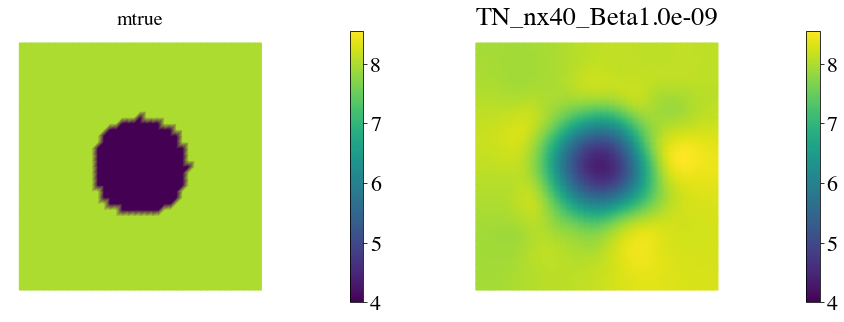

****** Computing solution with gamma =  1e-10 ******


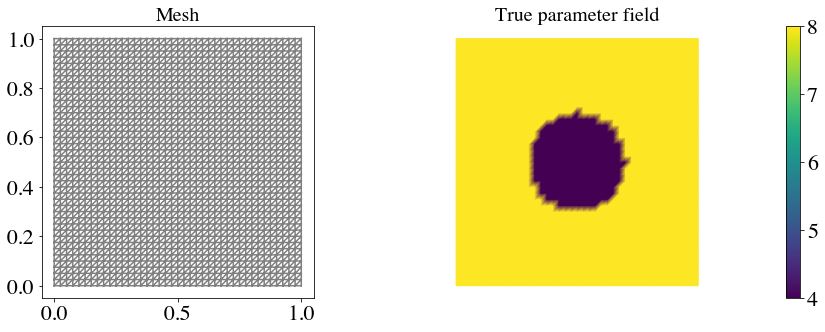

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     3.53423e-06   3.53423e-06   3.15529e-13   8.33609e-03   2.92101e-05    1.00   5.000e-01
 2     1     2.02233e-06   2.02233e-06   2.00943e-13   1.71707e-03   6.59209e-06    1.00   4.751e-01
 3     4     1.28187e-06   1.27991e-06   1.95942e-09   1.29992e-03   2.42046e-06    1.00   2.879e-01
 4     1     1.19842e-06   1.19646e-06   1.96024e-09   4.08718e-04   1.40026e-06    1.00   2.189e-01
 5    15     1.16910e-06   1.16412e-06   4.97284e-09   2.93489e-04   3.30526e-07    1.00   1.064e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


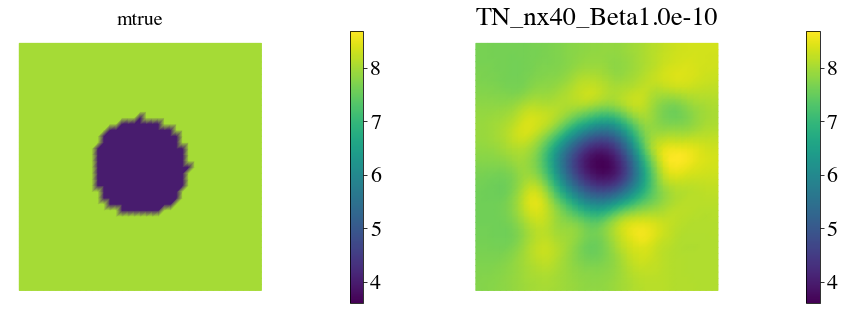

In [14]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n,n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.10, useTV=False)

****** Computing solution with gamma =  1e-07 ******


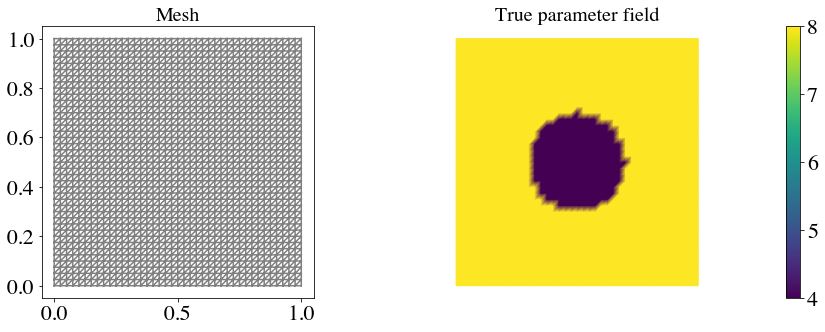

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40078e-06   2.40046e-06   3.15995e-10   8.34208e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90222e-07   8.90022e-07   2.00307e-10   1.71629e-03   6.63162e-06    1.00   4.763e-01
 3     2     6.40639e-07   4.88744e-07   1.51894e-07   7.12266e-04   2.47579e-06    1.00   2.910e-01
 4     2     6.25700e-07   4.73474e-07   1.52226e-07   1.72285e-04   5.91173e-07    1.00   1.422e-01
 5     5     6.24711e-07   4.55722e-07   1.68989e-07   4.40279e-05   1.60078e-07    1.00   7.400e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  11


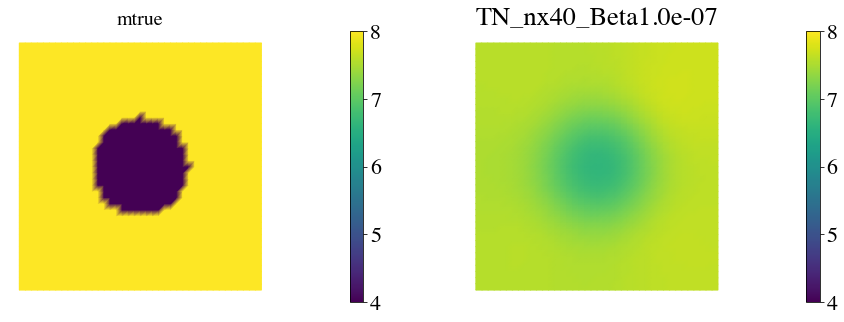

****** Computing solution with gamma =  1e-08 ******


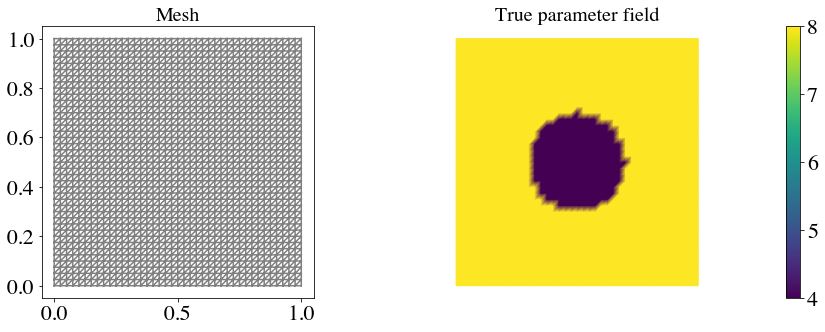

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40062e-06   2.40059e-06   3.16000e-11   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90067e-07   8.90047e-07   2.01243e-11   1.71628e-03   6.59294e-06    1.00   4.749e-01
 3     4     2.57755e-07   1.28229e-07   1.29526e-07   1.17970e-03   2.45465e-06    1.00   2.898e-01
 4     1     2.21672e-07   9.21065e-08   1.29566e-07   2.68645e-04   9.66631e-07    1.00   1.818e-01
 5     8     2.16543e-07   8.70727e-08   1.29470e-07   1.03179e-04   2.14340e-07    1.00   8.563e-02
Newton's method converged in  5   iterations
Total number of CG iterations:  15


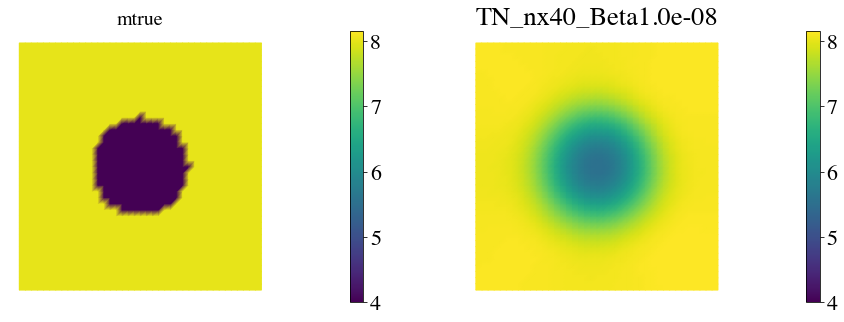

****** Computing solution with gamma =  1e-09 ******


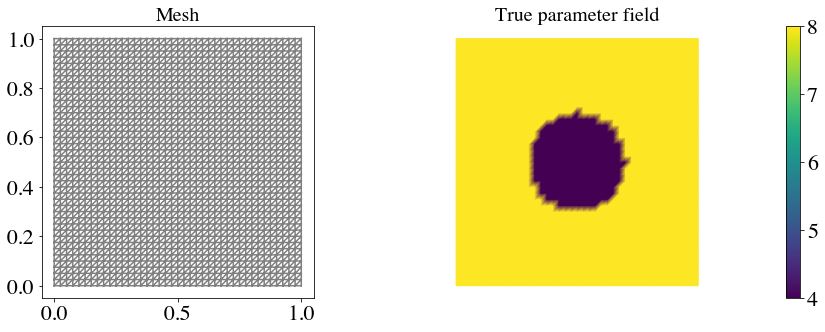

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40060e-06   2.40060e-06   3.16001e-12   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90051e-07   8.90049e-07   2.01337e-12   1.71628e-03   6.58907e-06    1.00   4.748e-01
 3     4     1.56852e-07   1.37901e-07   1.89510e-08   1.29372e-03   2.45256e-06    1.00   2.897e-01
 4     1     7.89440e-08   5.99855e-08   1.89586e-08   3.94951e-04   1.34723e-06    1.00   2.147e-01
 5     9     5.56203e-08   2.53150e-08   3.03052e-08   2.28095e-04   2.99159e-07    1.00   1.012e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  16


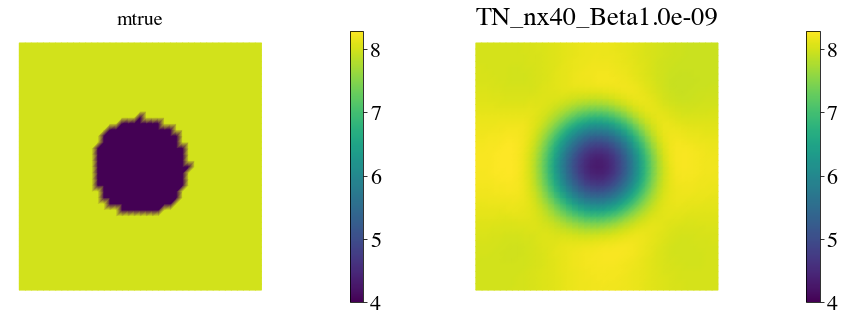

****** Computing solution with gamma =  1e-10 ******


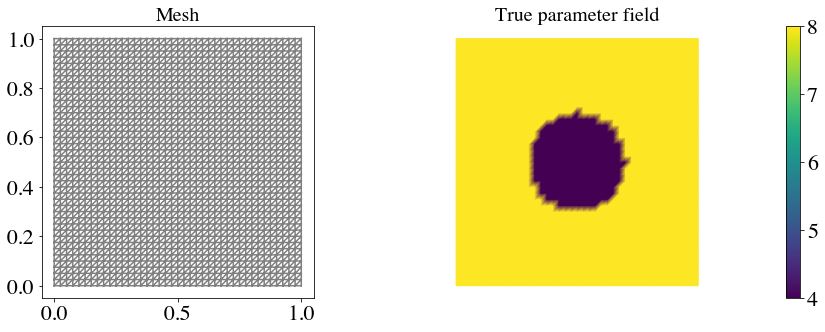

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40060e-06   2.40060e-06   3.16001e-13   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90050e-07   8.90049e-07   2.01346e-13   1.71628e-03   6.58869e-06    1.00   4.748e-01
 3     4     1.45222e-07   1.43244e-07   1.97715e-09   1.30712e-03   2.45235e-06    1.00   2.896e-01
 4     1     6.04232e-08   5.84452e-08   1.97796e-09   4.12060e-04   1.39859e-06    1.00   2.187e-01
 5    14     2.84545e-08   2.40379e-08   4.41659e-09   2.88386e-04   3.20965e-07    1.00   1.048e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


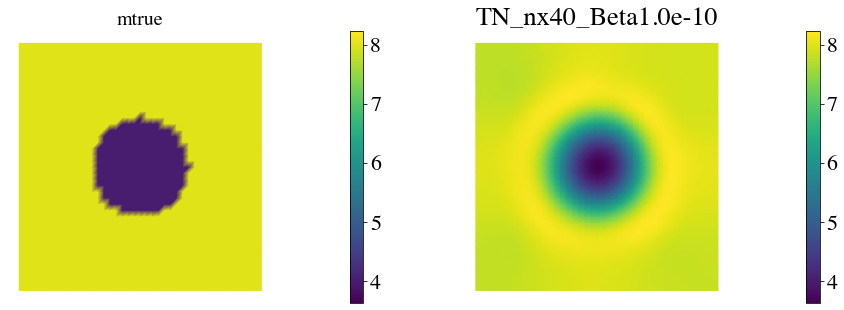

In [10]:
n = 40
gammas = [1e-7, 1e-8, 1e-9, 1e-10]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n,n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=False)

# Part 2.4: Tikhonov regularization with total variation regularization $\delta=0.001$

****** Computing solution with gamma =  1e-08 ******


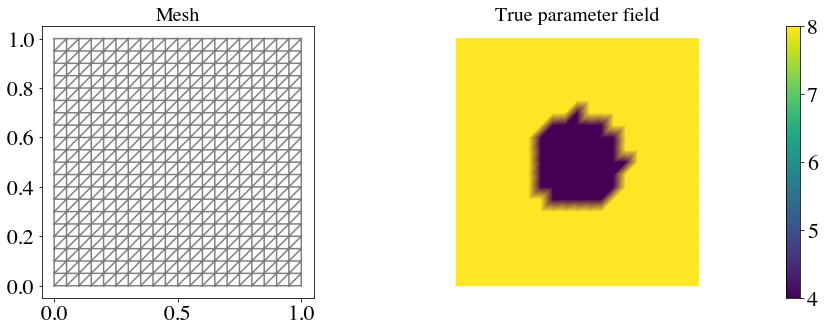

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39271e-06   2.39192e-06   7.92160e-10   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.87588e-07   8.86926e-07   6.62511e-10   1.71302e-03   6.66829e-06    1.00   4.794e-01
 3     2     2.36736e-07   2.04418e-07   3.23184e-08   1.14065e-03   2.45896e-06    1.00   2.911e-01
 4     1     2.13808e-07   1.81483e-07   3.23245e-08   2.13662e-04   1.40660e-06    1.00   2.202e-01
 5     5     9.34437e-08   5.32558e-08   4.01879e-08   4.69118e-04   1.09914e-06    1.00   1.946e-01
 6     4     7.96477e-08   3.84466e-08   4.12012e-08   1.43801e-04   3.05023e-07    1.00   1.025e-01
Newton's method converged in  6   iterations
Total number of CG iterations:  14


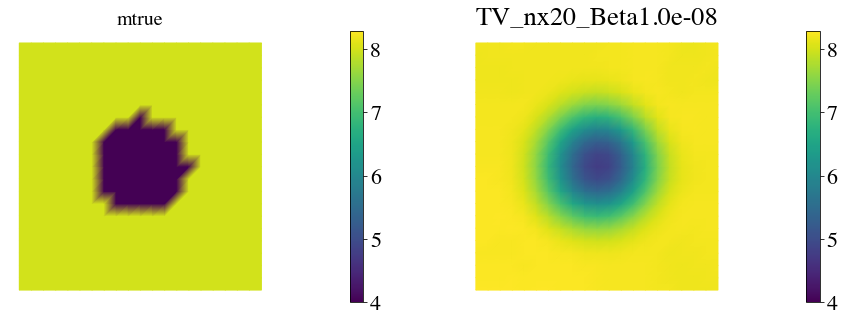

****** Computing solution with gamma =  1e-09 ******


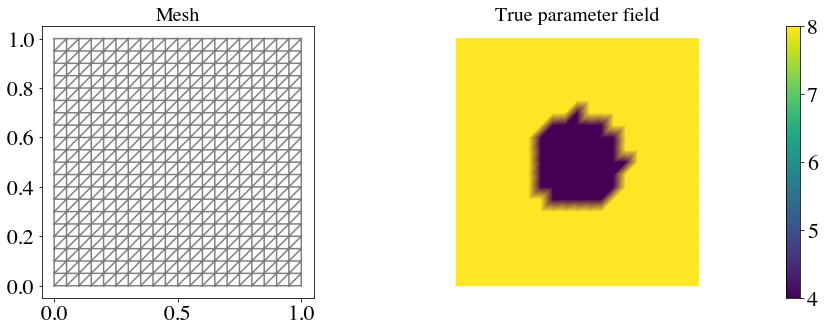

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39201e-06   2.39193e-06   7.92161e-11   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.87013e-07   8.86946e-07   6.63788e-11   1.71294e-03   6.63155e-06    1.00   4.781e-01
 3     4     1.42274e-07   1.38069e-07   4.20430e-09   1.29546e-03   2.43777e-06    1.00   2.899e-01
 4     1     6.04421e-08   5.62363e-08   4.20573e-09   4.04780e-04   1.38365e-06    1.00   2.184e-01
 5    10     2.72729e-08   2.23478e-08   4.92512e-09   2.53456e-04   3.07737e-07    1.00   1.030e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


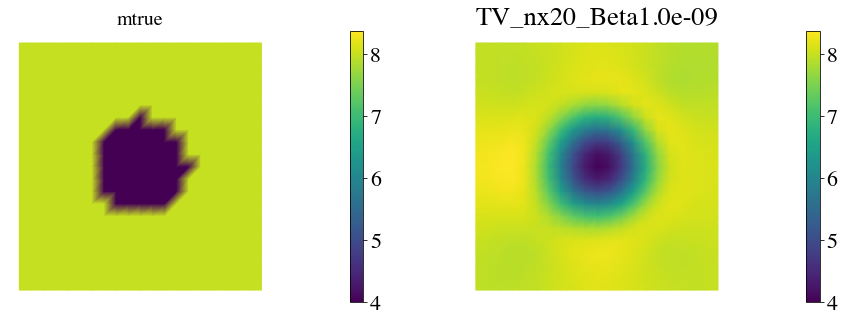

****** Computing solution with gamma =  1e-10 ******


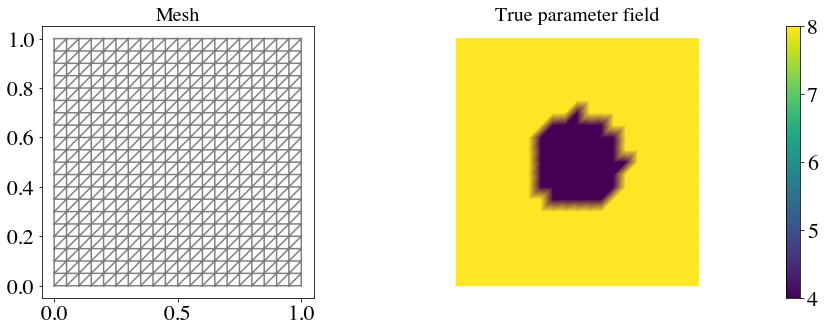

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39194e-06   2.39193e-06   7.92161e-12   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86955e-07   8.86949e-07   6.63916e-12   1.71293e-03   6.62790e-06    1.00   4.779e-01
 3     4     1.43764e-07   1.43336e-07   4.28387e-10   1.30690e-03   2.43570e-06    1.00   2.897e-01
 4     1     5.51960e-08   5.47675e-08   4.28529e-10   4.21123e-04   1.42790e-06    1.00   2.218e-01
 5    15     2.32199e-08   2.26750e-08   5.44835e-10   2.80977e-04   3.02231e-07    1.00   1.021e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


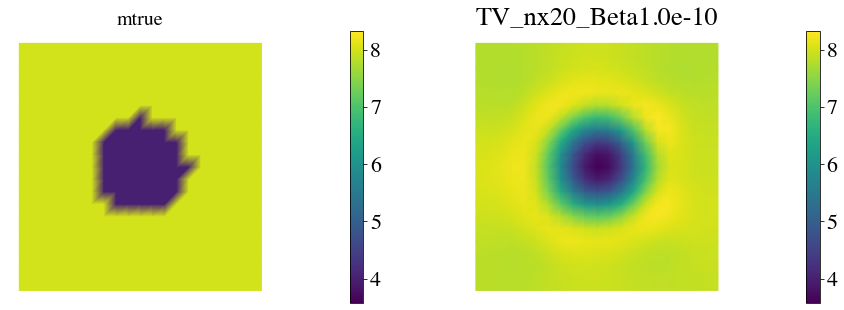

****** Computing solution with gamma =  1e-11 ******


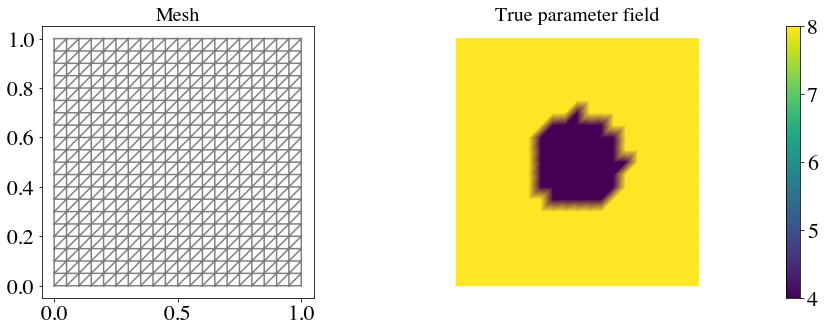

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39194e-06   2.39194e-06   7.92161e-13   8.28227e-03   2.90158e-05    1.00   5.000e-01
 2     1     8.86949e-07   8.86949e-07   6.63929e-13   1.71293e-03   6.62753e-06    1.00   4.779e-01
 3     4     1.43964e-07   1.43921e-07   4.29203e-11   1.30806e-03   2.43549e-06    1.00   2.897e-01
 4     1     5.46839e-08   5.46410e-08   4.29345e-11   4.22813e-04   1.43252e-06    1.00   2.222e-01
 5    14     2.35367e-08   2.34813e-08   5.54412e-11   2.84346e-04   3.01863e-07    1.00   1.020e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


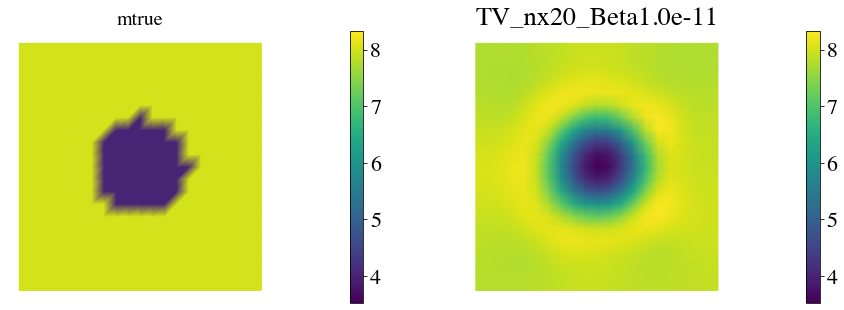

In [11]:
n = 20
gammas = [1e-8,1e-9, 1e-10,1e-11]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n, n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)


****** Computing solution with gamma =  1e-08 ******


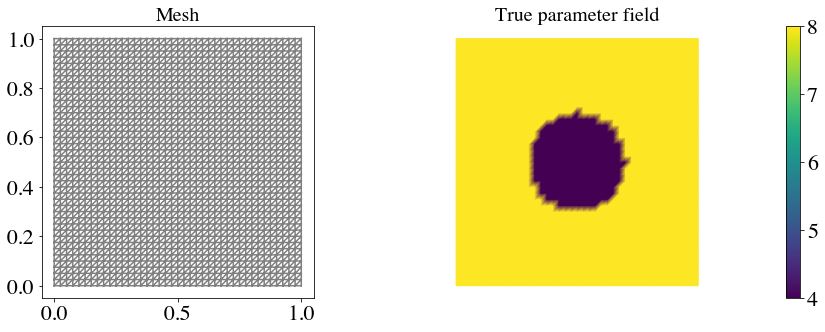

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40139e-06   2.40059e-06   7.99687e-10   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90696e-07   8.90027e-07   6.69650e-10   1.71637e-03   6.62923e-06    1.00   4.762e-01
 3     4     1.61910e-07   1.26721e-07   3.51893e-08   1.20255e-03   2.47481e-06    1.00   2.910e-01
 4     1     1.22772e-07   8.75688e-08   3.52034e-08   2.79819e-04   1.09212e-06    1.00   1.933e-01
 5     8     8.12515e-08   4.18127e-08   3.94388e-08   2.55324e-04   4.70104e-07    1.00   1.268e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  15


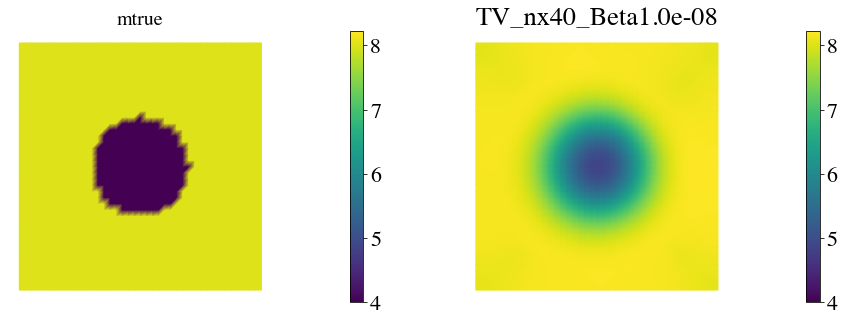

****** Computing solution with gamma =  1e-09 ******


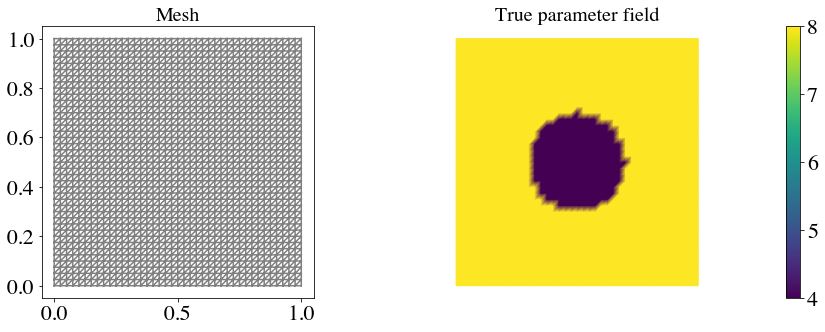

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40068e-06   2.40060e-06   7.99687e-11   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90114e-07   8.90047e-07   6.70945e-11   1.71629e-03   6.59269e-06    1.00   4.749e-01
 3     4     1.42544e-07   1.38417e-07   4.12786e-09   1.29619e-03   2.45452e-06    1.00   2.898e-01
 4     1     6.40252e-08   5.98960e-08   4.12924e-09   3.96501e-04   1.35725e-06    1.00   2.155e-01
 5    10     2.82574e-08   2.33715e-08   4.88589e-09   2.65125e-04   3.28263e-07    1.00   1.060e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


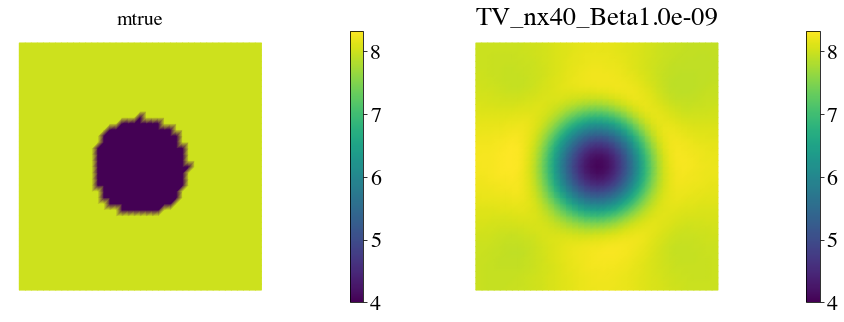

****** Computing solution with gamma =  1e-10 ******


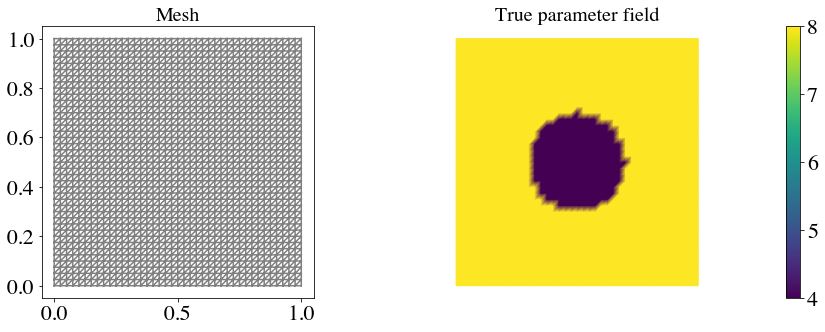

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40061e-06   2.40060e-06   7.99687e-12   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90056e-07   8.90049e-07   6.71075e-12   1.71628e-03   6.58905e-06    1.00   4.748e-01
 3     4     1.43726e-07   1.43306e-07   4.20444e-10   1.30737e-03   2.45254e-06    1.00   2.897e-01
 4     1     5.88619e-08   5.84414e-08   4.20582e-10   4.12221e-04   1.39956e-06    1.00   2.188e-01
 5    15     2.50133e-08   2.44811e-08   5.32264e-10   2.92976e-04   3.23880e-07    1.00   1.053e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


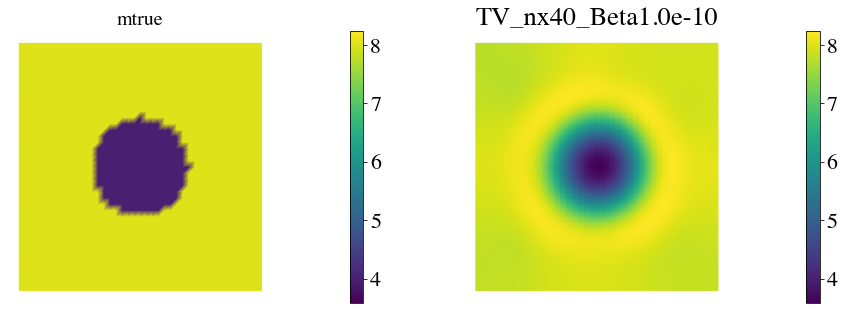

****** Computing solution with gamma =  1e-11 ******


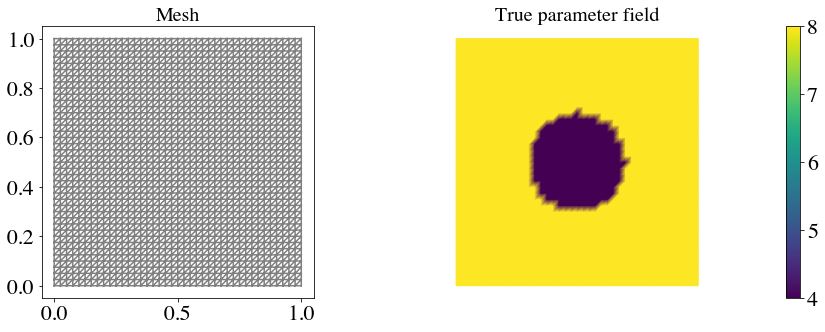

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.40060e-06   2.40060e-06   7.99472e-13   8.34212e-03   2.92316e-05    1.00   5.000e-01
 2     1     8.90039e-07   8.90038e-07   6.70767e-13   1.71628e-03   6.58869e-06    1.00   4.748e-01
 3     3     1.42597e-07   1.42555e-07   4.21228e-11   1.30840e-03   2.45232e-06    1.00   2.896e-01
 4     1     5.83691e-08   5.83270e-08   4.21365e-11   4.10672e-04   1.39377e-06    1.00   2.184e-01
 5    15     2.54787e-08   2.54246e-08   5.41123e-11   2.96329e-04   3.23667e-07    1.00   1.052e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  21


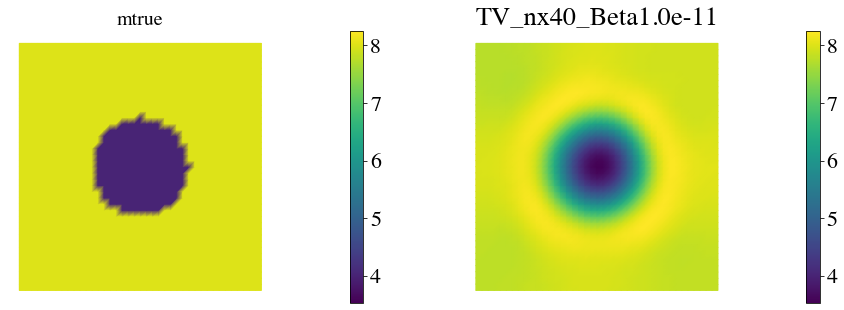

In [12]:
n = 40
gammas = [1e-8,1e-9, 1e-10,1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n,n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)

****** Computing solution with gamma =  1e-08 ******


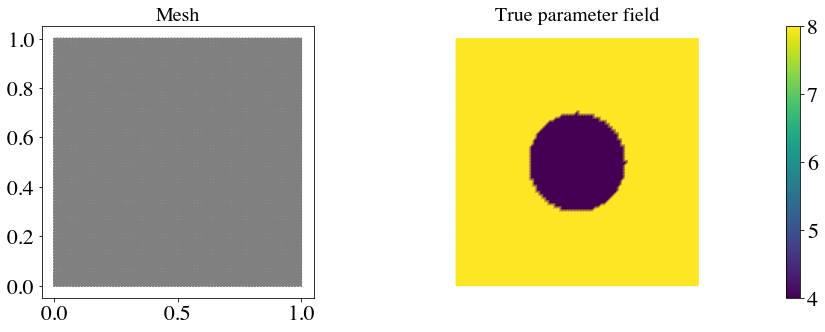

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39274e-06   2.39193e-06   8.03251e-10   8.37853e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77964e-07   8.77291e-07   6.72913e-10   1.71900e-03   6.59522e-06    1.00   4.739e-01
 3     4     1.61099e-07   1.26391e-07   3.47070e-08   1.19262e-03   2.45942e-06    1.00   2.894e-01
 4     1     1.24027e-07   8.93064e-08   3.47207e-08   2.72334e-04   1.06492e-06    1.00   1.904e-01
 5     8     8.23020e-08   4.33692e-08   3.89328e-08   2.56122e-04   4.71316e-07    1.00   1.267e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  15


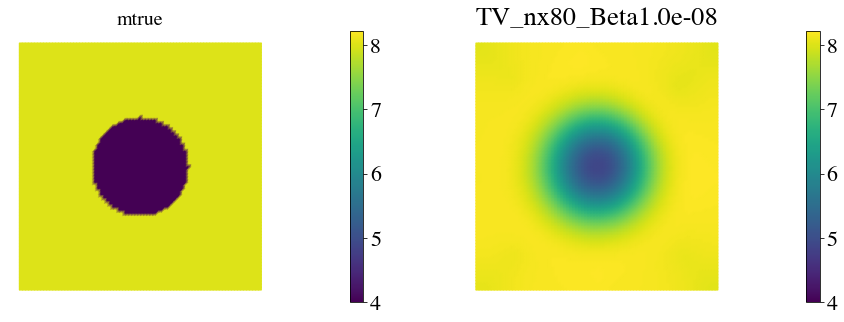

****** Computing solution with gamma =  1e-09 ******


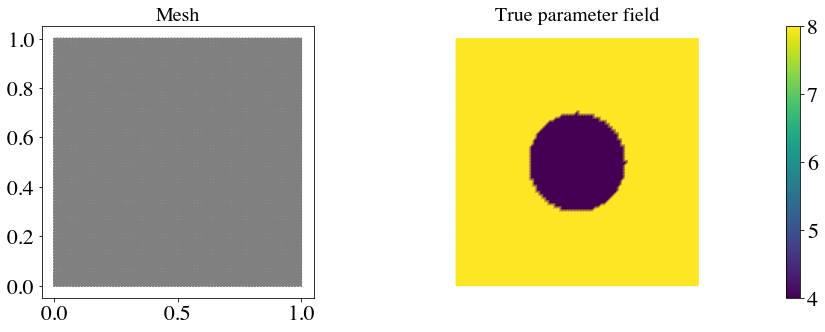

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39203e-06   2.39195e-06   8.03252e-11   8.37854e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77378e-07   8.77310e-07   6.74222e-11   1.71892e-03   6.55874e-06    1.00   4.726e-01
 3     4     1.40700e-07   1.36633e-07   4.06654e-09   1.28467e-03   2.43949e-06    1.00   2.882e-01
 4     1     6.65953e-08   6.25274e-08   4.06788e-09   3.85196e-04   1.31735e-06    1.00   2.118e-01
 5    10     2.93744e-08   2.45155e-08   4.85881e-09   2.70993e-04   3.34696e-07    1.00   1.068e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  17


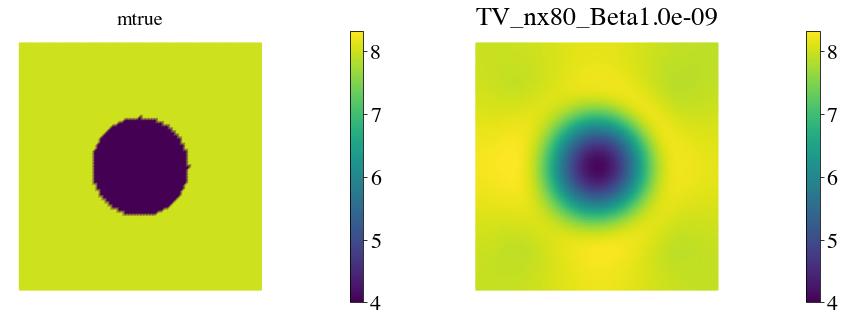

****** Computing solution with gamma =  1e-10 ******


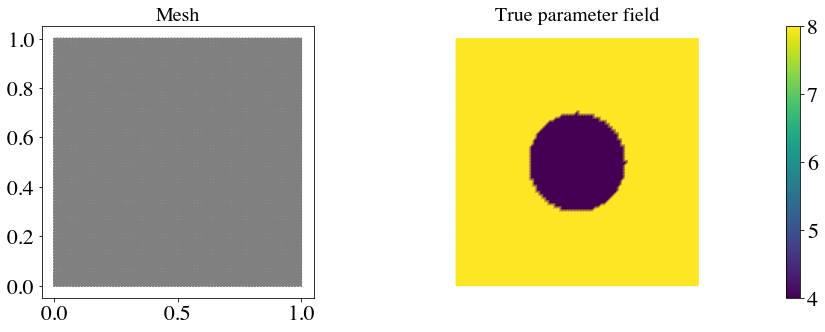

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39196e-06   2.39195e-06   8.03252e-12   8.37854e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77319e-07   8.77312e-07   6.74353e-12   1.71891e-03   6.55511e-06    1.00   4.724e-01
 3     4     1.41608e-07   1.41194e-07   4.14146e-10   1.29566e-03   2.43755e-06    1.00   2.881e-01
 4     1     6.15463e-08   6.11320e-08   4.14279e-10   4.00391e-04   1.35799e-06    1.00   2.150e-01
 5    15     2.65471e-08   2.60152e-08   5.31895e-10   2.99397e-04   3.30750e-07    1.00   1.061e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  22


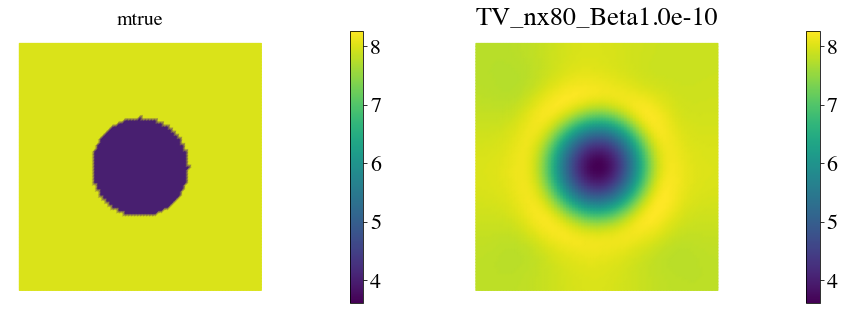

****** Computing solution with gamma =  1e-11 ******


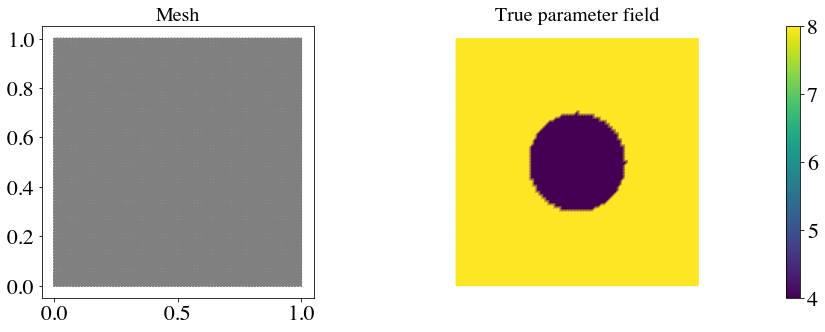

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     2.39195e-06   2.39195e-06   8.03155e-13   8.37854e-03   2.93696e-05    1.00   5.000e-01
 2     1     8.77309e-07   8.77309e-07   6.74313e-13   1.71891e-03   6.55475e-06    1.00   4.724e-01
 3     3     1.38648e-07   1.38607e-07   4.14902e-11   1.29651e-03   2.43734e-06    1.00   2.881e-01
 4     1     6.10654e-08   6.10239e-08   4.15032e-11   3.94143e-04   1.33712e-06    1.00   2.134e-01
 5    14     2.71111e-08   2.70570e-08   5.40774e-11   3.03003e-04   3.30462e-07    1.00   1.061e-01
Newton's method converged in  5   iterations
Total number of CG iterations:  20


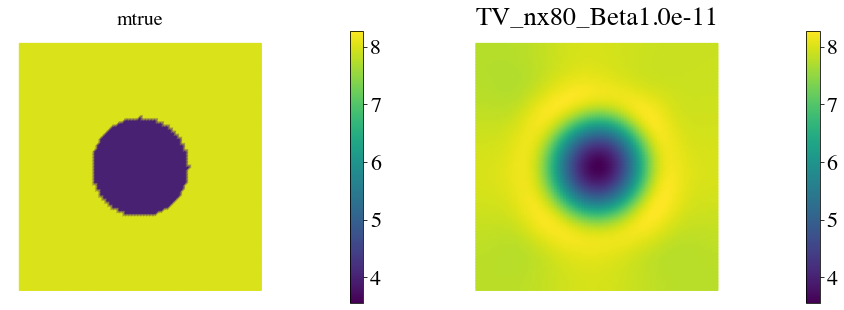

In [13]:
n = 80
gammas = [1e-8,1e-9, 1e-10,1e-11]
#gammas = [1e-8]
misfits = []

for gamma in gammas:
    print('****** Computing solution with gamma = ', gamma, '******')
    
    ndof, niter, ncgiter, noise_norm2, cost,misfit,reg = AddDiffInverseProblem(n,n, gamma, v = dl.Constant((1.0, 0.0))
                                                                               ,morozov = True, plot = True
                                                                               ,noise_level=0.01, useTV=True)

Copyright &copy; 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
Copyright &copy; 2019, The University of Texas at Austin, University of California--Merced, Washington University in St. Louis. <br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.